# **Store Sales - Time Series Forecasting**

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

## **0. 대회 소개**


- 시계열 예측을 사용하여 에콰도르 기반의 대형 식료품 소매업체인 Corporación Favorita의 `매장 판매량`을 예측하는 것
  - Favorita 매장에서 판매되는 수천 개의 제품군들의 `단위 판매량`을 더 정확하게 예측하는 모델을 구축하고자 함


#### **평가 지표**
- Root Mean Squared Logarithmic Error(`RMSLE`)
  - 다음과 같이 계산  
  $ \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $
  - $n$: 총 인스턴스 수
  - $ \hat{y}_i$: 인스턴스 $i$에 대한 타겟의 예측값
  - $y_i$는 인스턴스 $i$에 대한 타겟의 실제값

## **1. 데이터 살펴보기**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import calendar
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

### **1-1. 훈련 데이터**
- 날짜, 매장 및 제품 정보, 해당 제품이 프로모션되었는지 여부, 그리고 매출 숫자가 포함되어 있음
- 추가 파일에는 모델을 구축하는 데 유용할 수 있는 보충 정보가 포함되어 있음



#### **a) train.csv**  
- 학습용 데이터  

**컬럼 설명**   
- `id`: 각 데이터를 구분하기 위한 식별자
  - 300만 건의 데이터
- `date`: 판매일자
  - 기간) 2013/01/01 ~ 2017/08/15
- `store_nbr`: 매장 고유 식별번호
  - 1 ~ 54번
- `family`: 판매되는 제품 유형
  - 33개의 제품군
- `sales`: 특정 날짜에 특정 매장에서 제품군의 총 매출
  - 제품은 분수 단위로 판매될 수 있기 때문에 소수 값이 가능  
    (예: 1.5 kg의 치즈, 1 봉지의 감자칩 등)  
- `onpromotion`: 특정 날짜에 매장에서 프로모션되고 있는 제품군의 총 수량

In [5]:
train = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project/방학프로젝트/data/train.csv')
train.head(10)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


#### **b) stores.csv**
- 매장 메타데이터  

**컬렴 설명**
  - `store_nbr`: 매장 고유 식별번호
  - `city`: 매장이 위치한 도시
    - Quito, Guayaquil, Santa Domingo, Cuenca, Latacunga
  - `state`: 매장이 위치한 주
    - Pichincha, Guayas, Santo Domingo de los Tsachilas, Azuay, Manabi
  - `type`: 매장 유형
    - A, B, C, D, E
  - `cluster`: 유사한 매장들의 그룹
    - 1 ~ 17

In [7]:
stores = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project/방학프로젝트/data/stores.csv')
stores.head(10)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [8]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


#### **c) oil.csv**
- 일일 유가
- 학습 및 테스트 데이터 기간 모두의 값을 포함
- 에콰도르는 석유 의존국임
  - 석유 가격의 변동에 매우 취약함

**컬럼 설명**  
- `date`: 관측 일자
  - 기간) 2013/01/01 ~ 2017/08/31
- `dcoilwtico`: 유가

In [15]:
oil = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project/방학프로젝트/data/oil.csv')
oil.head(10)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


In [16]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


=> 유가에 1175개의 null 값이 존재한다. 이는 유가의 특성을 고려하여 백워드 필링 기법으로 채운다.

* 유가의 null 값 채우기

In [17]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [18]:
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='bfill')

In [19]:
oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

#### **d) holidays_events.csv**
- 휴일 및 이벤트 메타데이터
- `date`: 일자
  - 2012/03/12 ~ 2017/12/26
- `type` : 휴일 유형
  - Holiday, Event, Additional, Transfer, Bridge
- `locale`: 규모
  - National, Local, Regional
- `locale_name`: 지역명
  - Ecuador, Quito, Riobamba, Guaranda, Latacunga
- `description`: 설명
- `transferred`: 대체 여부
  - True, False


**Type**  
- Transfer
  - 달력상 날짜는 유지하되, 정부에 의해 다른 날짜로 변경된 휴일
  - 이렇게 변경된 날은 휴일로 취급되지만, 실제로는 일반적인 날과 유사함
> 실제 축하되는 날짜를 찾으려면 "type"이 "Transfer"인 해당 행을 확인하면 됨
  - 예를 들어, Independencia de Guayaquil 휴일은 2012-10-09에서 2012-10-12로 이전되었으며, 이는 2012-10-12에 실제로 축하된 것을 의미
- Bridge
  - 휴일 기간을 연장하기 위해 추가된 날짜
  - 이러한 날은 휴일로 취급되지만 실제로는 보통 근무일임
    - 이러한 날은 보통 Work Day 유형으로 보상됨
    > 휴일이 아닌 보통 근무일(예: 토요일)로, Bridge를 보상하기 위한 것
  - 대체공휴일 느낌
- Additional
  - 보통 달력상 휴일에 추가된 날짜
  - 일반적으로 크리스마스 주변에 발생하며, 이러한 날은 일반적인 휴일로 취급됨

In [51]:
holidays_events = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project/방학프로젝트/data/holidays_events.csv')
holidays_events.head(10)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [52]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [53]:
holidays_events['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [54]:
holidays_events['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [55]:
holidays_events['date'] = pd.to_datetime(holidays_events['date'], errors='coerce')

* date 열을 기준으로 중복된 행 제거

In [56]:
holidays_events = holidays_events.drop_duplicates(subset=['date'])

* 주말인 경우, 매출에 긍정적인 영향을 미칠 것이므로 day_week 변수를 추가한다.

In [57]:
# 요일 정보 추가
holidays_events['day_week'] = holidays_events['date'].dt.dayofweek

In [58]:
# 주말 또는 평일 여부 설정
holidays_events['weekend_yes'] = 0
holidays_events.loc[holidays_events['day_week'] > 4, 'weekend_yes'] = 1

In [59]:
holidays_events['weekend_yes']

0      0
1      1
2      0
3      1
4      1
      ..
344    0
346    1
347    1
348    0
349    0
Name: weekend_yes, Length: 312, dtype: int64

In [60]:
# day_week 삭제
holidays_events = holidays_events.drop(columns=['day_week'])

* transfer==True인 열 삭제

    transfer은 달력상 날짜는 유지하되, 정부에 의해 다른 날짜로 변경된 휴일이다. 이는 holidey 열에 정보가 포함되어 있으므로 삭제해도 된다.

In [61]:
# transferred==True 행 삭제
holidays_events = holidays_events[holidays_events['transferred'] != True]

* description 열 삭제

    이는 설명을 담고 있는 변수로 예측에 영향을 미치지 않을거라 판단되므로 삭제

In [62]:
# description 삭제
holidays_events = holidays_events.drop(columns=['description'])

In [63]:
holidays_events

,date,type,locale,locale_name,transferred,weekend_yes
0,2012-03-02,Holiday,Local,Manta,False,0
1,2012-04-01,Holiday,Regional,Cotopaxi,False,1
2,2012-04-12,Holiday,Local,Cuenca,False,0
3,2012-04-14,Holiday,Local,Libertad,False,1
4,2012-04-21,Holiday,Local,Riobamba,False,1
...,...,...,...,...,...,...
344,2017-12-22,Holiday,Local,Salinas,False,0
346,2017-12-23,Additional,National,Ecuador,False,1
347,2017-12-24,Additional,National,Ecuador,False,1
348,2017-12-25,Holiday,National,Ecuador,False,0


#### **e) transaction.csv**
- 거래 데이터로, 매장에 방문한 사람 수 또는 하루에 생성된 송장 수를 의미
  - 학습 데이터의 매출(sales) 컬럼과 매우 상관 관계가 있음
  - 이를 통해 매장의 매출 패턴을 이해할 수 있음
- `date`: 일자
  - 2013/01/01 ~ 2017/08/15
- `store_nbr`: 가게 고유번호
- `transactions`: 거래량

In [64]:
transaction = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project/방학프로젝트/data/transactions.csv')
transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [65]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


### **1-2. 테스트 데이터**
- 기간) 2017/08/16 ~ 2017/08/31

In [66]:
test = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project/방학프로젝트/data/test.csv')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [67]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


### **1-3. 제출용 파일**

In [68]:
sample_submission = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project/방학프로젝트/data/sample_submission.csv')
sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


## **2. 데이터 병합**
- `date`열의 경우 datetime으로 데이터형 변환 후 병합
- `train`의 모든 행은 결과 데이터프레임에 포함되며, 병합하려는 데이터프레임의 정보는 병합 대상인 열을 기준으로 매칭되는 경우에만 병합

### **2-1. train + oil**
- `date`열을 기준으로 병햡

In [69]:
# date 열을 datetime으로 변환
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])

# 날짜를 기준으로 merge
train = pd.merge(train, oil, on = 'date', how = 'left')
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,93.14


### **2-2. train + holidays_events**
- `date`열을 기준으로 병햡

In [70]:
# date 열을 datetime으로 변환
train['date'] = pd.to_datetime(train['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

# 날짜를 기준으로 merge
train = pd.merge(train, holidays_events, on = 'date', how = 'left')
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type,locale,locale_name,transferred,weekend_yes
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,False,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,False,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,False,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,False,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,False,0.0


### **2-3. train + transaction**
- EDA 시에는 활용 가능
- 모델 학습 시에는 활용하기 어려울 듯
  - test 데이터가 수집된 시점에 대해 거래 데이터가 없음
  - 일단은 병합 x

### **2-4. train + stores**
- `store_nbr`을 기준으로 병합

In [71]:
# 매장 고유번호를 기준으로 merge
train = pd.merge(train, stores, on = 'store_nbr', how = 'left')
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,locale_name,transferred,weekend_yes,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,False,0.0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,False,0.0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,False,0.0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,False,0.0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,False,0.0,Quito,Pichincha,D,13


### **2-5. 병합 결과 확인**

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 16 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   dcoilwtico   float64       
 7   type_x       object        
 8   locale       object        
 9   locale_name  object        
 10  transferred  object        
 11  weekend_yes  float64       
 12  city         object        
 13  state        object        
 14  type_y       object        
 15  cluster      int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(8)
memory usage: 389.2+ MB


In [73]:
train.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico      857142
type_x         2567862
locale         2567862
locale_name    2567862
transferred    2567862
weekend_yes    2567862
city                 0
state                0
type_y               0
cluster              0
dtype: int64

In [74]:
train.head(5)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,locale_name,transferred,weekend_yes,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,False,0.0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,False,0.0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,False,0.0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,False,0.0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,False,0.0,Quito,Pichincha,D,13


## **3. EDA**

### **3-1. Sales**

In [75]:
train_copy = train.copy()

In [76]:
train_copy = train_copy.groupby('date').mean()[['sales']].reset_index()

train_copy['date'] = pd.to_datetime(train_copy['date'])
train_copy['year'] = train_copy['date'].dt.year
train_copy['month'] = train_copy['date'].dt.month
train_copy['weekofyear'] = train_copy['date'].dt.weekofyear
train_copy['day'] = train_copy['date'].dt.day
train_copy['dayofweek'] = train_copy['date'].dt.day_name()

<ipython-input-76-1765d5ee4c13>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_copy = train_copy.groupby('date').mean()[['sales']].reset_index()
<ipython-input-76-1765d5ee4c13>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train_copy['weekofyear'] = train_copy['date'].dt.weekofyear


In [77]:
train_copy.head()

,date,sales,year,month,weekofyear,day,dayofweek
0,2013-01-01,1.409438,2013,1,1,1,Tuesday
1,2013-01-02,278.390807,2013,1,1,2,Wednesday
2,2013-01-03,202.840197,2013,1,1,3,Thursday
3,2013-01-04,198.911154,2013,1,1,4,Friday
4,2013-01-05,267.873244,2013,1,1,5,Saturday


**(1) sales**

* 일별 매출 평균

In [78]:
# 'date', 'sales', 'onpromotion' 열만 선택하여 새로운 데이터프레임 생성
train_aux = train[['date', 'sales', 'onpromotion']].groupby('date').mean()
train_aux = train_aux.reset_index()

# 산점도 그래프 생성
fig = go.Figure(data=go.Scatter(x=train_aux['date'],
                                y=train_aux['sales'],
                                marker_color='red', text="sales"))

# 그래프 레이아웃 업데이트
fig.update_layout({"title": f'전체 상점 및 제품의 날짜별 평균 판매량',
                   "xaxis": {"title":"날짜"},
                   "yaxis": {"title":"평균 판매량"},
                   "showlegend": False})

fig.show()

=> 매출이 점차 증가하는 추세이다.

=> 2015년 7월 이후 안정적인 추세를 보인다.

* 주당 매출 평균

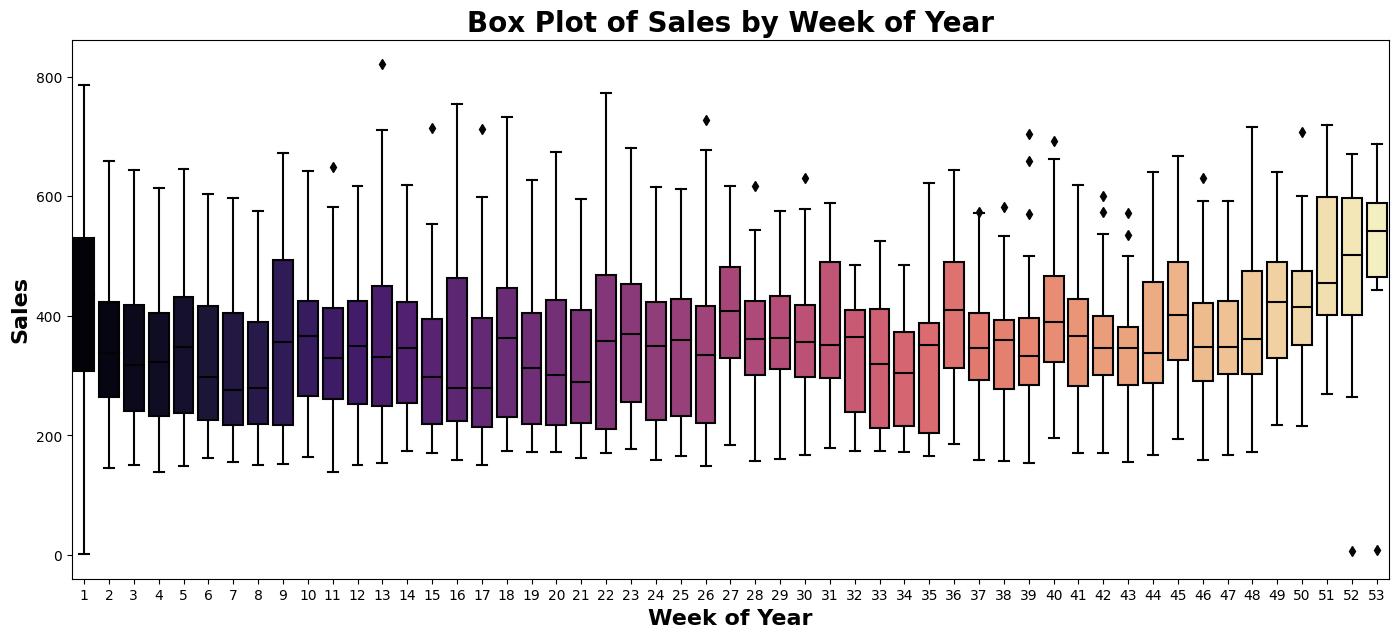

In [79]:
fig = plt.figure(figsize=(17,7))
sns.boxplot(x=train_copy['weekofyear'], y=train_copy['sales'], palette="magma")

plt.title('Box Plot of Sales by Week of Year', fontsize=20, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Week of Year', fontsize=16, fontdict=dict(weight='bold'))
plt.ylabel('Sales', fontsize=16, fontdict=dict(weight='bold'))

plt.show()

=> 각 년의 첫째주와, 마지막 3주의 매출이 가장 높다.

* 월별 매출 평균

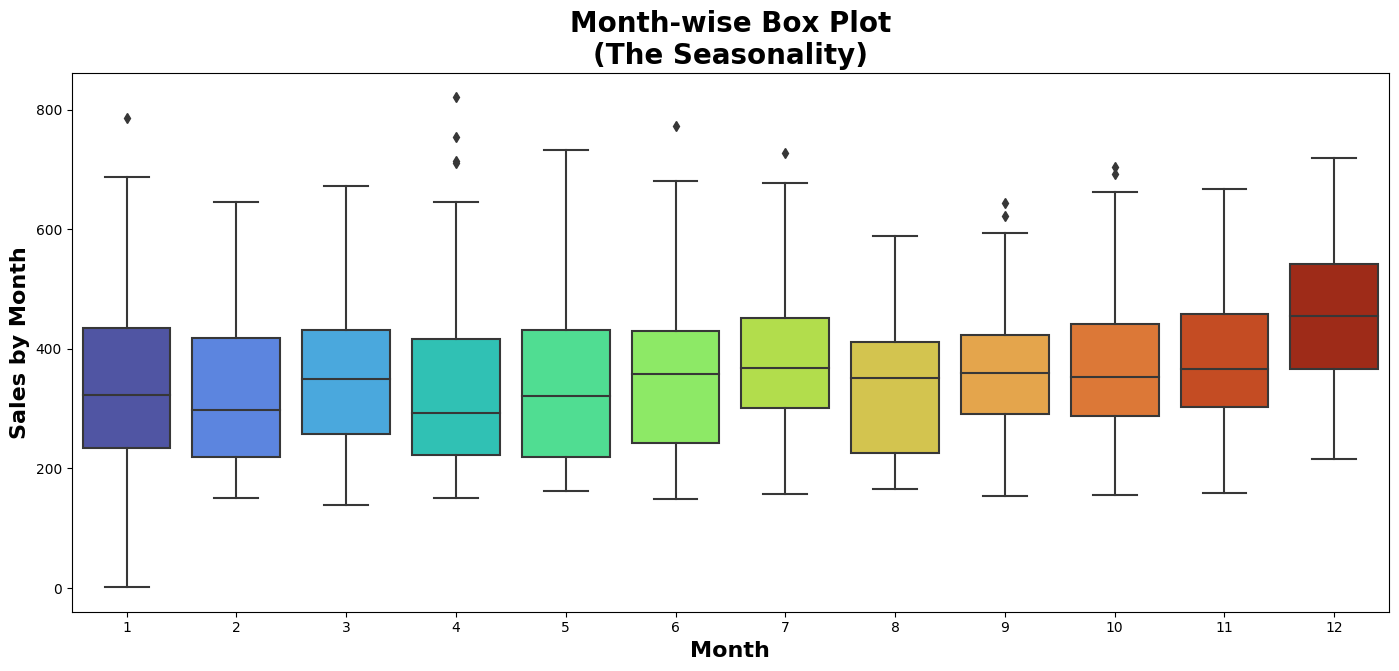

In [80]:
fig = plt.figure(figsize=(17,7))

sns.boxplot(x=train_copy['month'], y=train_copy['sales'], palette="turbo")

plt.title('Month-wise Box Plot\n(The Seasonality)', fontsize=20, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Month', fontsize=16, fontdict=dict(weight='bold'))
plt.ylabel('Sales by Month', fontsize=16, fontdict=dict(weight='bold'))

plt.show()

=> 12월의 매출이 다른 달보다 높은 편이다.

* 년도별 매출 평균

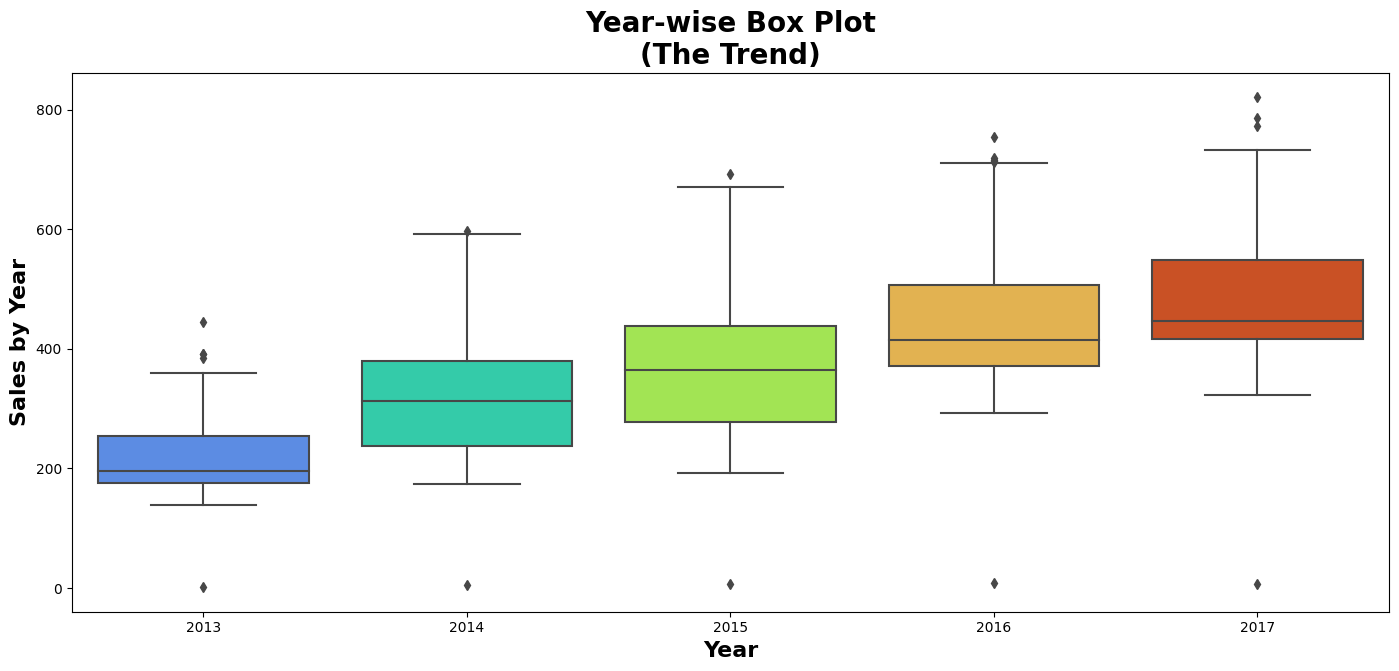

In [81]:
fig = plt.figure(figsize=(17,7))

sns.boxplot(x=train_copy['year'], y=train_copy['sales'], palette="turbo")

plt.title('Year-wise Box Plot\n(The Trend)', fontsize=20, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Year', fontsize=16, fontdict=dict(weight='bold'))
plt.ylabel('Sales by Year', fontsize=16, fontdict=dict(weight='bold'))

plt.show()

=> 년도가 지나면서 매출이 상승하고 있으며, 상승 폭은 작아지고 있다.

* 요일별 매출

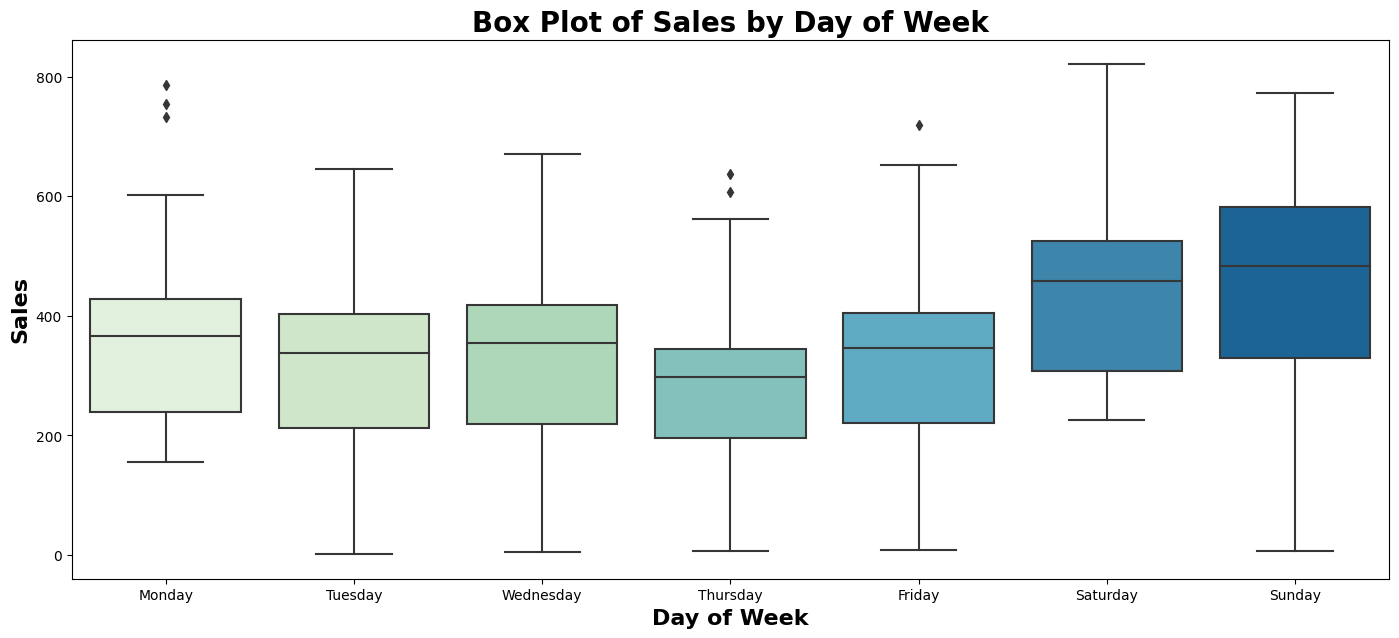

In [82]:
fig = plt.figure(figsize=(17,7))
sns.boxplot(x=train_copy['dayofweek'], y=train_copy['sales'], palette="GnBu",
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.title('Box Plot of Sales by Day of Week', fontsize=20, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Day of Week', fontsize=16, fontdict=dict(weight='bold'))
plt.ylabel('Sales', fontsize=16, fontdict=dict(weight='bold'))

plt.show()

=> 주말에 매출이 가장 높으며, 세번째로 높은 요일은 월요일이다.

**(2) sales와 다른 변수**

* onpromotion과 sales

In [83]:
fig = px.scatter(train_aux[train_aux['onpromotion'] > 0], x="onpromotion", y="sales", color='sales',
                           color_continuous_scale="earth",
                 size='sales', log_x=True, size_max=30)

fig.update_layout({"title": f'Correlation between OnPromotion and Sales (total avg sales and promotion on each day)',
                   "xaxis": {"title":"On Promotion"},
                   "yaxis": {"title":"Sales"},
                   "showlegend": False})
fig.show()

* type_y와 sales

In [84]:
df_st_sa = train[:train.shape[0]].groupby('type_y').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)

fig = make_subplots(rows=1, cols=1,
                    specs=[[{"type": "pie"}]],
                    subplot_titles=("Highest Sales in Stores"))

fig.add_trace(go.Pie(values=df_st_sa['sales'], labels=df_st_sa['type_y'],
                     marker=dict(colors=['#334668', '#496595', '#6D83AA', '#91A2BF', '#C8D0DF']),
                     hole=0.7, hoverinfo='label+percent+value', textinfo='label'),
              row=1, col=1)

fig.update_layout(height=300, bargap=0.2,
                  margin=dict(b=0, r=20, l=20),
                  title_text="Highest Sales in Stores",
                  template="plotly_white",
                  title_font=dict(size=15, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)

fig.show()

=> A 상점 type인 경우 매출이 가장 높다.

* family와 sales


In [85]:
df_fa_sa = train[:train.shape[0]].groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
df_fa_sa['color'] = '#496595'
df_fa_sa['color'][2:] = '#c6ccd8'

fig = make_subplots(rows=1, cols=1,
                    specs=[[{"type": "bar"}]],
                    subplot_titles=("Top 10 Highest Product Sales"))

fig.add_trace(go.Bar(x=df_fa_sa['sales'], y=df_fa_sa['family'], marker=dict(color=df_fa_sa['color']),
                     name='Family', orientation='h'),
              row=1, col=1)

# 그래프 스타일링
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_layout(height=300, bargap=0.2,
                  margin=dict(b=0, r=20, l=20),
                  title_text="Top 10 Highest Product Sales",
                  template="plotly_white",
                  title_font=dict(size=15, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)

fig.show()

<ipython-input-85-8e4222c901bd>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



* cluster와 sales

In [86]:
df_cl_sa = train[:train.shape[0]].groupby('cluster').agg({"sales" : "mean"}).reset_index()
df_cl_sa['color'] = '#c6ccd8'

fig = make_subplots(rows=1, cols=1,
                    specs=[[{"type": "bar"}]],
                    column_widths=[0.7], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Clusters Vs Sales"))

fig.add_trace(go.Bar(x=df_cl_sa['cluster'], y=df_cl_sa['sales'],
                     marker=dict(color= df_cl_sa['color']), name='Cluster'),
                     row=1, col=1)

# styling
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_cl_sa.cluster, ticktext=[i for i in range(1,17)], row=1, col=1)
fig.update_layout(height=400, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=15, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

### **3-2. Holidays_events**

**(1) type_x**

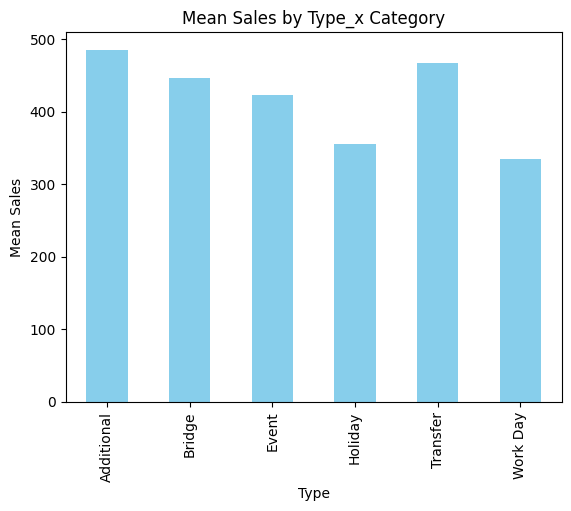

In [87]:
mean_sales_by_category = train.groupby('type_x')['sales'].mean()

fig, ax = plt.subplots()
mean_sales_by_category.plot(kind='bar', ax=ax, color='skyblue')
ax.set_xlabel('Type')
ax.set_ylabel('Mean Sales')
ax.set_title('Mean Sales by Type_x Category')
plt.show()

=> Additional, Bridge, Transfer의 평균 sales가 높으며, 이 경우 매출에 영향을 미친다고 볼 수 있다.

**(2) locale**

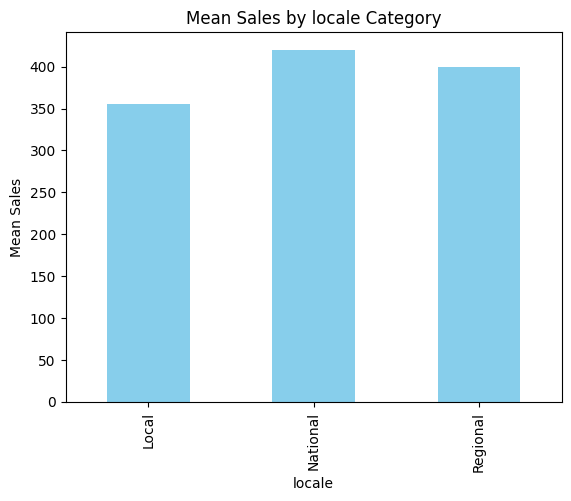

In [88]:
mean_sales_by_category = train.groupby('locale')['sales'].mean()

fig, ax = plt.subplots()
mean_sales_by_category.plot(kind='bar', ax=ax, color='skyblue')
ax.set_xlabel('locale')
ax.set_ylabel('Mean Sales')
ax.set_title('Mean Sales by locale Category')
plt.show()

### **3-2. Oil price**

**(1) dcoilwtico**

In [89]:
train_aux = train[['date', 'sales']].groupby('date').mean()
train_aux = train_aux.reset_index()
fig = go.Figure(data=go.Scatter(x=oil['date'],
                                y=oil['dcoilwtico'],
                                marker_color='blue', text="sales"))


fig.update_layout({"title": f'Oil Prices Chart',
                   "xaxis": {"title":"Date"},
                   "yaxis": {"title":"Oil Price"},
                   "showlegend": False})
fig.show()

=> 위 그래프에서 볼 수 있듯이 유가 흐름을 3기로 나누어 볼 수 있다. 이 중 첫 번째와 마지막인 2013~Jul2014, 2015 ~ Jul2107은 각각 기복이 있는 안정된 흐름을 보이고 있다. 다만, 두 번째인 Jul2014 ~ Jan2015에서는 유가가 상당히 하락하는 모습을 보인다.